# Introduction

Graph Neural Networks (GCNs) are an extension of the familiar Convolutional Neural Network to arbitrary topologies. Given the graph $G=\{V,E\}$, Gilmer et al. (2017) define the message-passing framework of GCNs as

$$x_{i}^{l+1} = \Theta^{l}(n_{i}^{l},\gamma(x_{i}^{l},\{x_{j}^{l}:j\in{}N^{1}_{i}\},e_{ij}))$$

where $N_{i}^{1}$ is the 1-neighborhood of vertex $n_{i}$, and $l$ indexes the $l$-th layer of the model. Both $x_{i}^{l}\in{}R^{n}$ and $x_{i}^{l+1}\in{}R^{m}$ are feature vectors associated with $n_{i}$. We refer to $\gamma{}$ as our aggregation function; typical choices are the sum or max operators, but some more exotic options do exist(ie: LSTMs). $\Theta$ is a neural network of some description, often a single linear layer [1].

While GCNs are fairly well-studied, we have a limited understanding of how well they capture the topological information of $G$. The literature finds clear benefit to incorporating structural features into GCNs; in particular:

* Pretraining a GCN on various centrality tasks improves the accuracy of downstream classifiers [2]. 
* Appending Laplacian eigenvectors to vertex features surpasses existing benchmark performance, in some cases quite significantly [3].
* Retaining centrality information produces more discriminative node embeddings [4]. 

This motivates our desire to assess the capability of GCNs in learning graph structure and develop means by which said capability may be improved. Thus far, [5] is the only work in a similar vein; however, they do not report experimental parameters. Their model also assigns each node a fixed ID, so we do not know how general their results are. [6] demonstrates the applicability of ML to learning topological graph metrics, but it predates the advent of GCNs.

## Model Code

It is convient to classify GCNs into two groups: node-wise convolutions and edge-wise convolutions. The former processes all edges equivalently i.e: $\gamma$ is independent of $x_{i}$ and $x_{j}$ for $e_{ij}$. This allows us to generalize to varied topologies without much in the way of computational cost. The prototypical example of a node-wise GCN is the GraphConv architecture [7]:

$$x_{i}^{l+1} = \Theta_{1}^{l}(x_{i}^{l}) + \Theta_{2}^{l}(\sum_{j\in{}N_{i}^{1}}w_{ij}x_{j}^{l})$$

$w_{ij}$ is the scalar weight assocaited with $e_{ij}$. The model employs two feedforward networks, $\Theta_{1}$ and $\Theta_{2}$, which can project the features of the target node and those aggregated from $N_{i}^{l}$ into different subspaces of $R^{m}$. Assuming both $\Theta$ are  $R^{m\times{}n}$ matrices, each GraphConv layer is $O(|V|mn + |E|n)$ in time and $O(|V|n + |E|)$ in space.

In many cases, it is actually beneficial to operate on *pairs* of node features, and for that we require edge-wise convolutions, of which the most prominent are the Graph Attention Network (GAT) [8] and its derivatives. GAT is notoriously memory and runtime intensive (the authors originally encountered problems on the fairly small PubMed benchmark), and edge-wise information is only incorporated into the attention coefficients, as opposed to the actual feature representations. We instead choose to focus on EdgeConv [9]:

$$x_{i}^{l} = \sum_{j\in{}N_{i}^{1}}w_{ij}\Theta{}^{l}(x_{i}^{l}||x_{j}^{l}-x_{i}^{l})$$

If $\Theta$ is restricted to a $R^{m\times{}2n}$ matrix, EdgeConv possesses a layerwise time complexity of $\textit{O}(|E|mn)$ and a $\textit{O}(|V|n + |E|n)$ space complexity.

Our implementations follow each layer with a LeakyReLU activation [11]. We also unit-normalize the columns of the feature matrix $X^{l}$.  BatchNorm [10] is a popular normalization scheme for GCNs; however, because we are training over relatively small batches of distinct networks, the expectations tend to be rather unstable.

In [1]:
import torch
import torch_geometric
import torch_sparse
import torch_scatter
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.optimize

# GraphConv Model
class GraphConv(torch.nn.Module):
    # in_channels and out_channels are self-explanatory. int_channels is the number of 
    # features in the intermediate layers. Depth controls the number of aggregations.
    def __init__(self,in_channels,int_channels,out_channels,depth,norm=True):
        super(GraphConv,self).__init__()
        self.start = torch.nn.Linear(in_channels,int_channels)
        self.intermediate = torch.nn.ModuleList([torch.nn.ModuleList([torch.nn.Linear(int_channels,int_channels),\
                                                                      torch.nn.Linear(int_channels,int_channels)])\
                                                 for _ in range(depth)])
        self.n = torch.nn.ModuleList([torch_geometric.nn.GraphSizeNorm() for _ in range(depth)])
        self.finish = torch.nn.Linear(int_channels,out_channels)
        self.norm = norm
        
    def forward(self,X,edge_index,edge_weight,batch):
        # Project to int_channels
        X = self.start(X)
        
        # Run through GraphConv layers
        for idx,m in enumerate(self.intermediate):
            X = m[0](X) + torch_scatter.scatter_sum(edge_weight[:,None] * m[1](X)[edge_index[1]], edge_index[0],dim=0)
            if self.norm: X = X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch]
            X = torch.nn.LeakyReLU()(X)

        # Project to out_channels
        return self.finish(X)

# EdgeConv Model
class EdgeConv(torch.nn.Module):
    
    # in_channels and out_channels are self-explanatory. int_channels is the number of 
    # features in the intermediate layers. Depth controls the number of aggregations.
    def __init__(self,in_channels,int_channels,out_channels,depth):
        super(EdgeConv,self).__init__()
        self.start = torch.nn.Linear(in_channels,int_channels)
        self.intermediate = torch.nn.ModuleList([torch.nn.Linear(2*int_channels,int_channels) for _ in range(depth)])
        self.n = torch.nn.ModuleList([torch_geometric.nn.GraphSizeNorm() for _ in range(depth)])
        self.finish = torch.nn.Linear(int_channels,out_channels)
        
    def forward(self,X,edge_index,edge_weight,batch):
        # Project to int_channels
        X = self.start(X)
        
        # Run through EdgeConv layers
        for idx,m in enumerate(self.intermediate):
            Z = torch.cat((X[edge_index[0]],X[edge_index[0]] - X[edge_index[1]]),dim=1)
            X = torch_scatter.scatter_sum(edge_weight[:,None] * m(Z), edge_index[0],dim=0)
            
            X = torch.nn.LeakyReLU()(X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch])
            
        # Project to out_channels
        return self.finish(X)

## Training Code

Graph centrality measures are used to quantify the structural properties of a network. By training GCNs to predict more and more complex centralities, we hope to gain insight into how well they incorporate topology and what limitations they posses, if any. Depending on our algorithm's performance, there may also be various practical applications. For example, path-based centralities (betweenness, closeness, etc) are broadly $\textit{O}(|V|^{3})$ and, at best, $\textit{O}(|V||E|)$ [19], so an accurate GCN approximation may be of interest in analyzing larger networks. 

Following the example of [5], we define our loss as the MAE between the model output, $\vec{x}$, and the targeted centrality scores, $\vec{y}$. We normalize both vectors instead of min-max scaling them, as this facilitates better comparison.  

$$\vec{x}' = \frac{\vec{x}}{||\vec{x}||_{2}}$$

$$L(\vec{x},\vec{y}) = \frac{1}{|V|}\sum_{i=0}^{|V|}|\vec{x_{i}}' - \vec{y_{i}}'|$$

Centrality is often used to compare individual nodes and ascertain some manner of "relevance". To reflect this, we also wanted to included a ranking measure as an added metric. Let $\vec{u}$ and $\vec{s}$ be vectors in $R^{k}$. Then the rank displacement is given as follows:

$$r_{disp}(\vec{u},\vec{s})=\frac{1}{k(k-1)}\sum_{i=0}^{k-1}\frac{1}{(1+f(s_{i},\vec{s}))^{n}}|f(u_{i},\vec{u}) - f(s_{i},\vec{s})|$$

$f$ is the *argsort* function i.e: the mapping $f(x_{i},\vec{x})\rightarrow{}r$ where $r=|\{x_{j}:x_{j} > x_{i} \forall{} x_{j}\in{}\vec{x}\}|$. Rank displacement captures the difference in rank between corresponding elements of $\vec{u}$ and a target $\vec{s}$. We can choose the constant $n$ to place greater emphasis on $s_{i}$ of higher rank; in all experiments, we set $n=.6$.

In [1]:
# L1 Norm w/ Min-Max normalization
def scaled_MAE(X,Y,batch):
    X = X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch]
    Y = Y/torch_scatter.scatter_sum(Y**2,batch,dim=0).sqrt()[batch]
    return torch.mean((X - Y).abs())

def symmetric_cosine(X,Y,batch):
    X = X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch]
    Y = Y/torch_scatter.scatter_sum(Y**2,batch,dim=0).sqrt()[batch]
    return torch.mean(1 - torch_scatter.scatter_sum(X*Y,batch,dim=0).abs())

# Computes Min-Max norm
def normalize(X,batch):
    Min = -torch_scatter.scatter_max(-X,batch,dim=0)[0][batch]
    Max = torch_scatter.scatter_max(X,batch,dim=0)[0][batch]
    return (X-Min)/(1e-12 + Max - Min)

# Gets rank (descending) of each element in X
def get_rank(X):
    val,inv_val = X.unique(return_inverse=True)
    return torch.argsort(torch.argsort(val,descending=True))[inv_val]

# Compute rank displacement
def rank_disp(X,Y,batch):
    L = 0
    for idx,b in enumerate(batch.unique()):
        X_rank,Y_rank = get_rank(X[batch==b]),get_rank(Y[batch==b])
        l = (X_rank.float() - Y_rank.float()).abs()/(1+Y_rank.float())**(.6)
        L += l.sum()/torch.numel(X_rank - 1)
    return L/(idx+1)

In [3]:
# Takes GCN model and data loaders.
def train_loop(model,train_loader,test_loader,epochs,lr=1e-3,metric_func=rank_disp,loss_func=scaled_MAE):
    train_loss = []
    test_loss = []
    metric = []

    try: 
        opt = torch.optim.Adam(model.parameters(),lr=lr)
    except: pass;
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])

    model.eval()
    with torch.no_grad():
        ts,r = 0,0
        for idx,data in enumerate(test_loader):
            X,Y,edge_index,edge_weight = data.x.cuda(),data.y.cuda(),data.edge_index.cuda(),data.edge_weight.cuda()
            batch = data.batch.cuda()

            preds = model(X,edge_index,edge_weight,batch)

            loss = loss_func(preds.squeeze(),Y,batch)

            ts += loss.item()
            r += metric_func(preds.squeeze(),Y,batch).item()

    metric.append(r/(idx+1))
    test_loss.append(ts/(idx+1))
    
    # Iterate over epochs
    for epoch in range(epochs):
        tr,ts,r = 0,0,0
        
        # Compute train error and backprop.
        model.eval()
        for idx,data in enumerate(train_loader):
            X,Y,edge_index,edge_weight = data.x.cuda(),data.y.cuda(),data.edge_index.cuda(),data.edge_weight.cuda()
            batch = data.batch.cuda()

            preds = model(X,edge_index,edge_weight,batch)
            loss = loss_func(preds.squeeze(),Y,batch)

            try: 
              loss.backward()
              opt.step()
              opt.zero_grad()
            except: pass;

            tr += loss.item()
        train_loss.append(tr/(idx+1))

        # Compute test error and rank displacement
        model.eval()
        with torch.no_grad():
            for idx,data in enumerate(test_loader):
                X,Y,edge_index,edge_weight = data.x.cuda(),data.y.cuda(),data.edge_index.cuda(),data.edge_weight.cuda()
                batch = data.batch.cuda()

                preds = model(X,edge_index,edge_weight,batch)

                loss = loss_func(preds.squeeze(),Y,batch)

                ts += loss.item()
                r += metric_func(preds.squeeze(),Y,batch).item()

        metric.append(r/(idx+1))
        test_loss.append(ts/(idx+1))
        
    # Return average values per epoch
    return train_loss,test_loss,metric

# Takes model and test_loader. 
def eval_loop(model,test_loader,metric_func=rank_disp,loss_func=scaled_MAE):
    model.eval()
    with torch.no_grad():
      ts,r = 0,0
    
      # Compute mean test error and rank
      for idx,data in enumerate(test_loader):
          X,Y,edge_index,edge_weight = data.x.cuda(),data.y.cuda(),data.edge_index.cuda(),data.edge_weight.cuda()
          batch = data.batch.cuda()

          preds = model(X,edge_index,edge_weight,batch)

          loss = loss_func(preds.squeeze(),Y,batch)
          ts += loss.item()
          r += metric_func(preds.squeeze(),Y,batch).item()

      # Return metrics
      return ts/(idx+1),r/(idx+1)

## Dataset

We generate random networks via a Stochastic Block Model (SBM) [12]. Given probability matrix $P\in{}R^{k\times{}k}$ and $k$ clusters, a Stochastic Block Model defines the network wherein $p(e_{ij})=P_{c_{i},c_{j}}$ for cluster assignments $c_{i},c_{j}$. This allows us to model a wide range of topologies [3,12]. As a starting point, we produce a synthetic dataset of 250 highly-connected SBMs with cluster size $n\sim{}U(50,100)$, $k=5$, and $P\sim{}U(\frac{1}{n},\frac{10}{n})$. Features are uninformative, being the vector $\vec{1}\in{}R^{|V|}$. $80\%-20\%$ train-test split.

In [6]:
if __name__=="__main__":
    num_graphs = 250
    d = []

    for _ in range(num_graphs):

        # Get Cluster sizes and connection probabilities
        n = torch.randint(50,100,(5,))
        p = 1/n + (10/n - 1/n) * torch.rand((5,5))
        p = .5 * (p + p.T)

        # Generate SBM
        x,edges = torch.randn((n.sum(),1)),torch_geometric.utils.remove_isolated_nodes(torch_geometric.utils.stochastic_blockmodel_graph(n,p))[0]
        adj = torch_sparse.SparseTensor(row=edges[0],col=edges[1])

        # Create TorchGeometric Data object
        d.append(torch_geometric.data.Data(x=x[:adj.size(0)],edge_index = edges))

We examine the relationship between the density,$\frac{2|E|}{|V|(|V|-1)}$, of an SBM and the ratio of its two largest eigenvalues, $\frac{|\lambda{}_{2}|}{|\lambda{}_{1}|}$. This latter quantity determines the similarity of $A^{k}\vec{x}$ to the dominant eigenvector of $A$, $\vec{v_{1}}$. If $||\vec{x}||=1$, then we have:

$$\vec{x} = (\vec{x}\cdot{}\vec{v_{1}})\vec{v_{1}} + (\vec{x}\cdot{}\vec{v_{2}})\vec{v_{2}} + ... + (\vec{x}\cdot{}\vec{v_{n}})\vec{v_{n}}$$

$$A^{k}\vec{x} = \lambda_{1}^{k}(\vec{x}\cdot{}\vec{v_{1}})\vec{v_{1}} + \lambda_{2}^{k}(\vec{x}\cdot{}\vec{v_{2}})\vec{v_{2}} + ... + \lambda_{n}^{k}(\vec{x}\cdot{}\vec{v_{n}})\vec{v_{n}}$$

where $(\lambda_{i},\vec{v_{i}})$ are the various eigenpairs of $A$. For sufficiently large $k$,

$$A^{k}\vec{x} \approx{} \lambda_{1}^{k}(\vec{x}\cdot{}\vec{v_{1}})\vec{v_{1}} + \lambda_{2}^{k}(\vec{x}\cdot{}\vec{v_{2}})\vec{v_{2}} $$
$$=\lambda_{1}^{k}(\vec{x}\cdot{}\vec{v_{1}})(\vec{v_{1}} + (\frac{\lambda_{2}}{\lambda_{1}})^{k}(\frac{\vec{x}\cdot{}\vec{v_{2}}}{\vec{x}\cdot{}\vec{v_{1}}})\vec{v_{2}})$$

As $|\lambda_{2}|\leq{}|\lambda_{1}|$, the magnitude of the second term (i.e: the approximation error) will decay according to $(\frac{|\lambda_{2}|}{|\lambda_{1}|})^{k}$, or $\frac{|\lambda_{2}|}{|\lambda_{1}|}$ per additional matrix power.


In [12]:
if __name__=="__main__":
    num_samples = 100
    p_range = torch.linspace(.001,1,100)
    density = []
    eig_ratio = []

    # Iterate over range of connection probabilities
    for p in p_range:
        for _ in range(num_samples):

            # Get Cluster sizes and connection probabiltiies
            n = torch.randint(50,100,(5,))
            P = p * torch.ones((5,5))
            P = .5 * (P + P.T) 

            # Generate SBM
            x,edges = torch.randn((n.sum(),1)),torch_geometric.utils.remove_isolated_nodes(torch_geometric.utils.stochastic_blockmodel_graph(n,P))[0]
            adj = torch_sparse.SparseTensor(row=edges[0],col=edges[1])

            # Compute density and ratio of leading eigenvalues
            density.append(torch_sparse.sum(adj)/(adj.size(0)*adj.size(1)))

            vals = torch.sort(torch.norm(torch.eig(adj.to_dense())[0],dim=1))
            eig_ratio.append(vals[0][-2]/vals[0][-1])

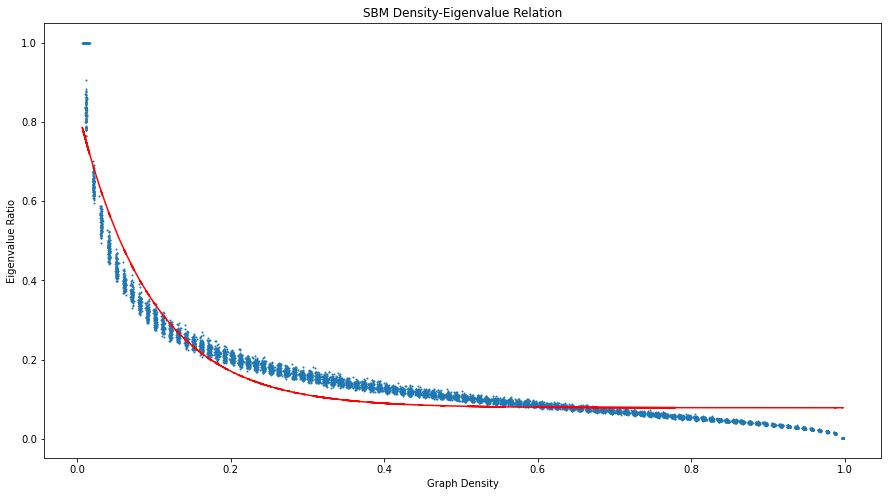

In [53]:
if __name__=="__main__":
    plt.figure(figsize=(15,8))
    plt.scatter(density,eig_ratio,s=1)
    
    f = lambda x,a,b,c,d: c * a ** (b*x) + d
    ppot,_ = scipy.optimize.curve_fit(f,density,eig_ratio)
    plt.plot(density,f(torch.Tensor(density).numpy(),ppot[0],ppot[1],ppot[2],ppot[3]),color='red')
    
    plt.xlabel('Graph Density')
    plt.ylabel('Eigenvalue Ratio')
    plt.title('SBM Density-Eigenvalue Relation');

We find that the relationship between density and the ratio of leading eigenvalues is roughly exponential with form $ba^{x}+c$, and we plot above the optimal least-squares approximation in red. In future chapters, we explore the effect of lower graph density (and hence a smaller eigenvalue ratio) on GCN performance. The average density of our current dataset is around $.1$, so $E[\frac{|\lambda_{2}|}{|\lambda_{1}|}]\approx{}.4$